In [1]:
"""
Create a simple N-body simulation.
"""

'\nCreate a simple N-body simulation.\n'

In [1]:
"""
Imports
"""

import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation,FFMpegWriter


In [2]:
"""
Initialise the particle distribution by writing it into a .csv.
"""

#bureau's problem - 3 stationary bodies with a pre-set arrangement of masses and positions
def init_bureau(filename="particles.csv"):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['m','x','y','vx','vy'])
        writer.writerow([5.,0.,0.,0.,0.])
        writer.writerow([3.,0.,4.,0.,0.])
        writer.writerow([4.,3.,0.,0.,0.])

#further arrangements below when available:        

#initialise
init_bureau()

In [13]:
"""
Read particle data into arrays from the .csv
Creates an initial list of masses, positions, velocities.
"""

def read_data(filename="particles.csv"):
    df = pd.read_csv(filename)
    masses = df['m'].values
    positions = df[['x', 'y']].values.astype(float) #ensure values read correctly
    velocities = df[['vx', 'vy']].values.astype(float)
    return masses, positions, velocities

masses, positions, velocities = read_data("particles.csv")

In [4]:
"""
Calculate the accelerations in the x and y directions acting on each particle.
Note: Softening length to prevent exponential inaccuracies, set to zero for now.
"""

def calculate_accelerations(masses, positions, G=6.674e-11, softening_length=0.0):
    n = len(masses)
    accelerations = np.zeros_like(positions, dtype=float)
    for i in range(n):
        for j in range(n):
            if i != j:
                r_vector = positions[j]  - positions[i]
                distance = np.linalg.norm(r_vector)
                distance_softened = (distance**2 + softening_length**2)**0.5
                if distance_softened == 0:
                    force = np.array([0.0,0.0])
                else:
                    force_magnitude = G*masses[i]*masses[j]/distance_softened**3
                    force = force_magnitude*r_vector
                accelerations[i] += force/masses[i]
    return accelerations

accelerations = calculate_accelerations(masses, positions, G=6.674e-11, softening_length=0.01)

In [5]:
"""
Define integrators
"""

#Basic integrator for now, direct euler integration
def integrate_euler(positions, velocities, accelerations, dt):
    velocities = velocities + accelerations * dt
    positions = positions + velocities * dt
    return positions, velocities

#define other integrators here:


#set the integrator
integrator = integrate_euler    

In [6]:
"""
Create the simulation
Args: csv (contains masses, positions, velocities), dt, time_scale
Function: Runs the simulation for time_scale/dt steps
Returns: position_history, velocity_history
"""

def run_simulation(csv, dt, time_scale):

    #set gravitational constant
    G=6.674e-11
    
    #read from csv
    masses, initial_positions, initial_velocities = read_data("particles.csv")
    particle_count = len(masses)

    #initialise simulation
    step_count = int(time_scale/dt)
    positions = initial_positions.copy()
    velocities = initial_velocities.copy()

    #initialise histories
    position_history = np.zeros((step_count+1, particle_count,2))
    velocity_history = np.zeros((step_count+1, particle_count,2))
    position_history[0] = positions.copy()
    velocity_history[0] = velocities.copy()

    #simulation loop
    for i in range(step_count):
    
        accelerations = calculate_accelerations(masses, positions, G, softening_length=0.1) #calculate accelerations
        positions, velocities = integrator(positions, velocities, accelerations, dt) #integrate
        position_history[i+1] = positions.copy() #update
        velocity_history[i+1] = velocities.copy()

        #print positions for first few steps and final position for analysis and debugging
        if i < 10:
            print(f"Time step {i+1}:")
            for j in range(particle_count):
                print(f"  Particle {j}: x = {positions[j, 0]}, y = {positions[j, 1]}")
            print("-" * 20)
        elif i == step_count -1:
            print(f"Time step {i+1}:")
            for j in range(particle_count):
                print(f"  Particle {j}: x = {positions[j, 0]}, y = {positions[j, 1]}")
            print("-" * 20)
    
    return position_history, velocity_history

In [10]:
"""
Run the simulation
"""

#run the simulation to produce relevant data
position_history, velocity_history = run_simulation(csv="particles.csv", dt=1, time_scale=1000000)

masses, initial_positions, initial_velocities = read_data("particles.csv")
print("Initial Positions:\n", initial_positions)

Time step 1:
  Particle 0: x = 2.961285375884074e-11, y = 1.2502027518040864e-11
  Particle 1: x = 6.403197697215418e-12, y = 3.9999999999706257
  Particle 2: x = 2.9999999999581815, y = 6.403197697215418e-12
--------------------
Time step 2:
  Particle 0: x = 8.883856127785753e-11, y = 3.7506082554323916e-11
  Particle 1: x = 1.920959309188527e-11, y = 3.999999999911877
  Particle 2: x = 2.9999999998745444, y = 1.920959309188527e-11
--------------------
Time step 3:
  Particle 0: x = 1.7767712255972097e-10, y = 7.50121651092518e-11
  Particle 1: x = 3.841918618448757e-11, y = 3.9999999998237543
  Particle 2: x = 2.999999999749089, y = 3.841918618448757e-11
--------------------
Time step 4:
  Particle 0: x = 2.961285376084369e-10, y = 1.250202751834285e-10
  Particle 1: x = 6.403197697573936e-11, y = 3.999999999706257
  Particle 2: x = 2.9999999995818154, y = 6.403197697573936e-11
--------------------
Time step 5:
  Particle 0: x = 4.4419280642934657e-10, y = 1.875304127776593e-10
  Pa

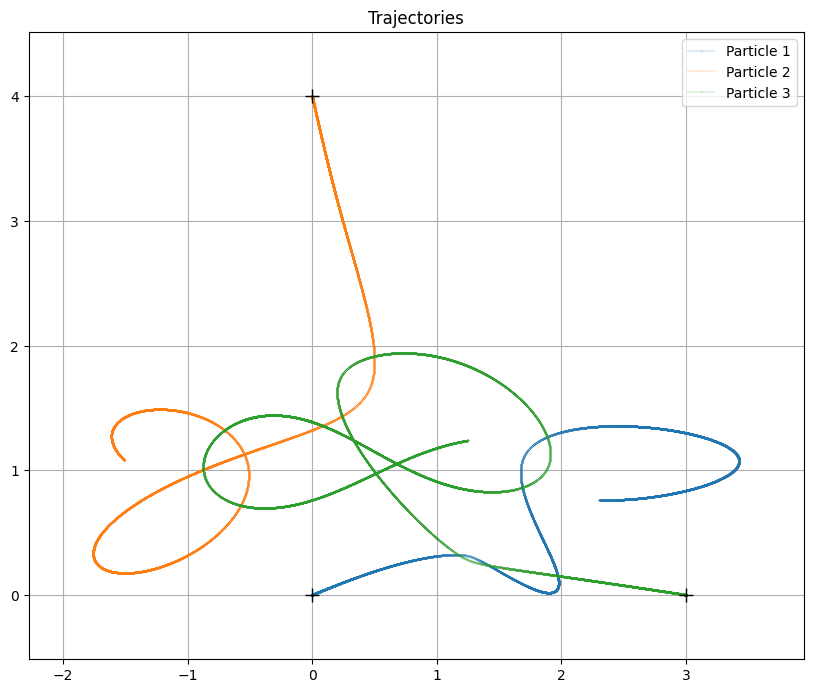

In [12]:
"""
Define the function that plots the position history
"""

def visualise(position_history, masses):
    step_count = position_history.shape[0]
    particle_count = position_history.shape[1]

    plt.figure(figsize=(10, 10))

    for i in range(particle_count):  # Correct loop over particles
        x = position_history[:, i, 0]  # All x-coordinates for particle i over all time steps
        y = position_history[:, i, 1]  # All y-coordinates for particle i over all time steps

        plt.plot(x, y, label=f"Particle {i + 1}", linewidth=0.2, marker='o', markersize=0.1, markevery=50)
    for i in range(particle_count):
        plt.plot(initial_positions[i, 0], initial_positions[i, 1], 'k+', markersize=10)

    plt.title("Trajectories")
    plt.legend(loc="upper right")
    plt.grid(True)

    x_min = np.min(position_history[:, :, 0])
    x_max = np.max(position_history[:, :, 0])
    y_min = np.min(position_history[:, :, 1])
    y_max = np.max(position_history[:, :, 1])
    margin = 0.1 * max(abs(x_max - x_min), abs(y_max - y_min))
    x_min -= margin
    x_max += margin
    y_min -= margin
    y_max += margin

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

visualise(position_history, masses)

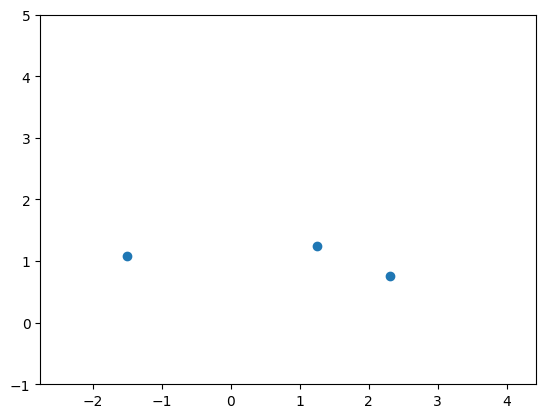

In [35]:
"""
Define the function that creates an animation from the simulation.
Uses FuncAnimation,FFMpegWriter
"""
#create a truncated position history equal to every nth entry in the main position history
truncated_positions = position_history[::69]

#truncated_positions shape (14493, 3, 2)
fig, ax = plt.subplots()

ax.set_xlim(np.min(truncated_positions[:,:,0]) - 1, np.max(truncated_positions[:,:,0]) + 1)
ax.set_ylim(np.min(truncated_positions[:,:,1]) - 1, np.max(truncated_positions[:,:,1]) + 1)

#Initialize scatter with positions of frame 0 or empty
scat = ax.scatter(truncated_positions[0,:,0], truncated_positions[0,:,1])

def init():
    scat.set_offsets(truncated_positions[0])
    return scat,

def update(frame):
    scat.set_offsets(truncated_positions[frame])
    return scat,

ani = FuncAnimation(fig, update, frames=len(truncated_positions), init_func=init, blit=True)

writer = FFMpegWriter(fps=24, metadata=dict(artist='Me'), bitrate=1800)
ani.save('nbody_animation.mp4', writer=writer)

plt.show()